**There are 3 data sets:**

* Votes : primary results for 28 states (2048 counties) - by state, county, party (Democrat/Republican), candidate, number of votes

    * 28 states: ['AL' 'AZ' 'AR' 'CO' 'FL' 'GA' 'ID' 'IL' 'IA' 'KY' 'LA' 'ME' 'MA' 'MI' 'MS' 'MO' 'NE' 'NV' 'NC' 'OH' 'OK' 'SC' 'TN' 'TX' 'UT' 'VT' 'VA' 'NH']
* County Facts : contains the demographic information for 51 states (3143 counties), such as races, ages, education, income, etc.

* County Data Dictionary: demographic codes and their description. e.g. PST045214 => 'Population, 2014 estimate'

**Data Exploration:**
* What's the corelation for demograhic information - e.g. 
    * College education and income are highly corelated.
    * The higher the population, the higher number of votes. (This is obvious.)
    * College degree and votes are highly corelated.
    * Income and votes are highly corelated.
* Who is the top candidate in each party  



**Supervised learning - logistic regression:**
* Given the available primary results for 28 states (2048 counties), to predict the winner for remaining states/counties for each party. 
* Note: does not intend to cover Delegates in this project - the data is not available nor am I interested.





In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression, LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.cross_validation import cross_val_score, train_test_split
import scipy.stats as stats

# visualization
%matplotlib inline
import seaborn as sns

In [78]:
#-- read file 1 - primary results
vote_data = pd.read_csv("../../data/2016_presidential_election/primary_results.csv")
vote_data.rename(columns={'fips': 'county_code'}, inplace=True)
print vote_data.shape
vote_data.head()

(13212, 8)


,state,state_abbreviation,county,county_code,party,candidate,votes,fraction_votes
0,Alabama,AL,Autauga,1001,Republican,Donald Trump,5387,0.445
1,Alabama,AL,Autauga,1001,Republican,Ted Cruz,2482,0.205
2,Alabama,AL,Autauga,1001,Republican,Marco Rubio,1785,0.148
3,Alabama,AL,Autauga,1001,Republican,Ben Carson,1764,0.146
4,Alabama,AL,Autauga,1001,Republican,John Kasich,421,0.035


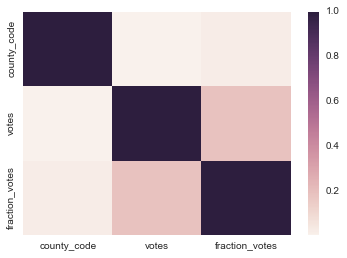

In [371]:
#-- data set 1 - initial exploration. There is not much meaning at this stage.
sns.heatmap(vote_data.corr())

In [72]:
#-- read file 2 - raw county facts data
county_facts_data_raw = pd.read_csv("../../data/2016_presidential_election/county_facts.csv")
print "original data set column number:", county_facts_data_raw.shape
#county_facts_data_raw.head()

#-- for file2 : initially pick 19 columns in interest (out of total 54 columns)
county_facts_data_combined = county_facts_data_raw[[ "fips", "area_name", "state_abbreviation" \
   , "PST045214", "AGE135214", "AGE295214", "AGE775214" , "SEX255214"\
   , "RHI125214", "RHI225214", "RHI325214", "RHI425214" , "RHI525214"\
   , "RHI625214", "RHI725214", "RHI825214"\
   , "EDU635213", "EDU685213", "INC910213" ]]
#county_facts_data_combined.head()

#-- Rename columns to be more readable. 
#-- Currently data still have both State Level and County Level, so call it combined for now.
county_facts_data_combined.columns = [ "county_code", "area_name", "state_abbreviation" \
    , "population_2014", "pct_age_below_5", "pct_age_below_18", "pct_age_above_65" \
   , "female_percent"\
   , "White_alone", "African_American", "Native_Indian", "Asian" , "Pacific_Islander"\
   , "Two_more_races", "Hispanic", "White"\
   , "HighSchool", "College", "Income" ]
#county_facts_data_combined.head()

#--drop first set of columns not interested.  
#--To enchance later - Could have be more automatic after find out the corelation and then drop columns not intrested.
county_facts_data_combined.drop(['White_alone','Native_Indian' \
                                 ,'Pacific_Islander','Two_more_races'
                                ], axis=1, inplace = True )

#--drop 2nd set of columns not interested, ditto to above
county_facts_data_combined.drop(['pct_age_below_5','pct_age_below_18' , 'pct_age_above_65'\
                                  , 'female_percent', 'HighSchool', 'area_name'
                                ], axis=1, inplace =True )

print "reduced data set column number :",county_facts_data_combined.shape

original data set column number: (3195, 54)
reduced data set column number : (3195, 9)


C:\Program Files (x86)\Anaconda2\lib\site-packages\ipykernel\__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Program Files (x86)\Anaconda2\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [79]:
print "The demographic data is mingled with State Level (NaN) and County Level data"
county_facts_data_combined.head()

The demographic data is mingled with State Level (NaN) and County Level data


,county_code,state_abbreviation,population_2014,African_American,Asian,Hispanic,White,College,Income
0,0,NaN,318857056,13.2,5.4,17.4,62.1,28.8,28155
1,1000,NaN,4849377,26.7,1.3,4.1,66.2,22.6,23680
2,1001,AL,55395,18.7,1.1,2.7,75.6,20.9,24571
3,1003,AL,200111,9.6,0.9,4.6,83.0,27.7,26766
4,1005,AL,26887,47.6,0.5,4.5,46.6,13.4,16829


In [80]:
#-- FYI
#-- read file 3 - county facts dictionary
county_facts_dd = pd.read_csv("../../data/2016_presidential_election/county_facts_dictionary.csv")
county_facts_dd.head(10)

,column_name,description
0,PST045214,"Population, 2014 estimate"
1,PST040210,"Population, 2010 (April 1) estimates base"
2,PST120214,"Population, percent change - April 1, 2010 to ..."
3,POP010210,"Population, 2010"
4,AGE135214,"Persons under 5 years, percent, 2014"
5,AGE295214,"Persons under 18 years, percent, 2014"
6,AGE775214,"Persons 65 years and over, percent, 2014"
7,SEX255214,"Female persons, percent, 2014"
8,RHI125214,"White alone, percent, 2014"
9,RHI225214,"Black or African American alone, percent, 2014"


Explore data set 2 again - after drop some more columns.  This now starts to show some info. 
**For example, Income and College are high corelated.**

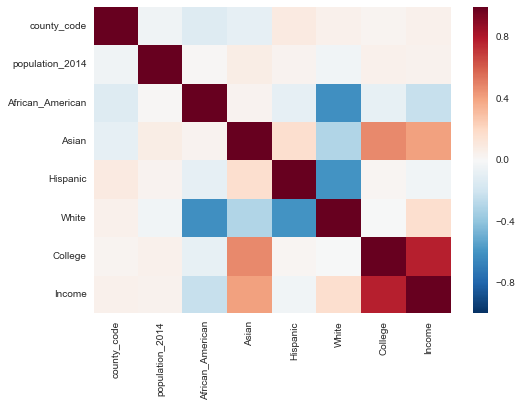

In [81]:
#-- explore data set 2  after drop some more columns.  This now starts to show some info.
#-- for example, Income and College are high corelated.
sns.heatmap(county_facts_data_combined.corr())

In [388]:
#sns.pairplot(county_facts_data_combined, x_vars=['African_American','Asian','Hispanic', 'White' ]
#                        , y_vars='Income', size=10, aspect=0.8)

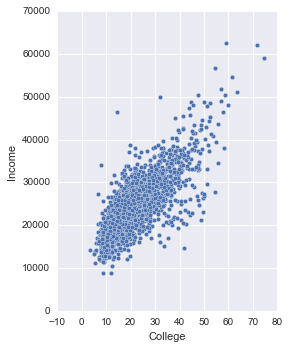

In [11]:
sns.pairplot(county_facts_data_combined, x_vars=['College'], y_vars='Income', size=5, aspect=0.8)

In [82]:
#-- TBA later - create a series of ones so can use to substract with pd
one_series = pd.Series(np.ones(county_facts_data_combined.shape[0])) *100
print one_series.shape
one_series.head(5)

(3195L,)


0    100.0
1    100.0
2    100.0
3    100.0
4    100.0
dtype: float64

print 100-43.8
print 100-44.2

--TBA later -  county_facts_data_combined : derive new columns
county_facts_data_combined['pct_age_above_18'] =  \
one_series  -county_facts_data_combined['pct_age_below_5'] \
- county_facts_data_combined['pct_age_below_18'] \
-county_facts_data_combined['pct_age_above_65'] 
type(zzz)
type(county_facts_data_combined)
county_facts_data_combined['zzz'] = zzz

In [83]:
#-- FYI, nice to have "State Level' facts data but we are not intrest this at the moment
#-- by select the rows of df where state_abbreviation IS NaN
state_facts_data = county_facts_data_combined[county_facts_data_combined\
                                              ['state_abbreviation'].isnull()]
print state_facts_data.shape
state_facts_data.head()

(52, 9)


,county_code,state_abbreviation,population_2014,African_American,Asian,Hispanic,White,College,Income
0,0,NaN,318857056,13.2,5.4,17.4,62.1,28.8,28155
1,1000,NaN,4849377,26.7,1.3,4.1,66.2,22.6,23680
69,2000,NaN,736732,3.9,6.1,6.8,61.9,27.5,32651
99,4000,NaN,6731484,4.7,3.3,30.5,56.2,26.9,25358
115,5000,NaN,2966369,15.6,1.5,7.0,73.4,20.1,22170


In [84]:
#-- We are interest in 'County Level' facts data:
#-- by select the rows of df where state_abbreviation is NOT NaN
county_facts_data = county_facts_data_combined[county_facts_data_combined\
                                               ['state_abbreviation'].notnull()]
print county_facts_data.shape
county_facts_data.head()

(3143, 9)


,county_code,state_abbreviation,population_2014,African_American,Asian,Hispanic,White,College,Income
2,1001,AL,55395,18.7,1.1,2.7,75.6,20.9,24571
3,1003,AL,200111,9.6,0.9,4.6,83.0,27.7,26766
4,1005,AL,26887,47.6,0.5,4.5,46.6,13.4,16829
5,1007,AL,22506,22.1,0.2,2.1,74.5,12.1,17427
6,1009,AL,57719,1.8,0.3,8.7,87.8,12.1,20730


In [87]:
#-- FYI - just to verify counts 
print county_facts_data.shape[0]
print state_facts_data.shape[0]
print county_facts_data_combined.shape[0]
if (county_facts_data.shape[0] + state_facts_data.shape[0] == county_facts_data_combined.shape[0] ):
        print 'Yes: counts match!'
else:
        print 'No : Counts do NOT match.'

3143
52
3195
Yes: counts match!


In [90]:
#-- so far we have 3 sets of data, and we are intrest between vote_data and county_facts_data

print vote_data.state_abbreviation.unique()
print "Number of states   in vote data set        : "\
                , len(vote_data.state_abbreviation.unique())
print "Number of counties in vote data set        : "\
                , len(vote_data.county_code.unique())
print
print county_facts_data.state_abbreviation.unique()
print "Number of states   in county facts data set : "\
            , len(county_facts_data.state_abbreviation.unique())
print "Number of counties in county facts data set : "\
            , len(county_facts_data.county_code.unique())

['AL' 'AZ' 'AR' 'CO' 'FL' 'GA' 'ID' 'IL' 'IA' 'KY' 'LA' 'ME' 'MA' 'MI' 'MS'
 'MO' 'NE' 'NV' 'NC' 'OH' 'OK' 'SC' 'TN' 'TX' 'UT' 'VT' 'VA' 'NH']
Number of states   in vote data set        :  28
Number of counties in vote data set        :  2048

['AL' 'AK' 'AZ' 'AR' 'CA' 'CO' 'CT' 'DE' 'DC' 'FL' 'GA' 'HI' 'ID' 'IL' 'IN'
 'IA' 'KS' 'KY' 'LA' 'ME' 'MD' 'MA' 'MI' 'MN' 'MS' 'MO' 'MT' 'NE' 'NV' 'NH'
 'NJ' 'NM' 'NY' 'NC' 'ND' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD' 'TN' 'TX' 'UT'
 'VT' 'VA' 'WA' 'WV' 'WI' 'WY']
Number of states   in county facts data set :  51
Number of counties in county facts data set :  3143


In [17]:
vote_data.head(3)  #-- data set 1

,state,state_abbreviation,county,county_code,party,candidate,votes,fraction_votes
0,Alabama,AL,Autauga,1001,Republican,Donald Trump,5387,0.445
1,Alabama,AL,Autauga,1001,Republican,Ted Cruz,2482,0.205
2,Alabama,AL,Autauga,1001,Republican,Marco Rubio,1785,0.148


In [18]:
county_facts_data.head(3)  #-- data set 2

,county_code,state_abbreviation,population_2014,African_American,Asian,Hispanic,White,College,Income
2,1001,AL,55395,18.7,1.1,2.7,75.6,20.9,24571
3,1003,AL,200111,9.6,0.9,4.6,83.0,27.7,26766
4,1005,AL,26887,47.6,0.5,4.5,46.6,13.4,16829


In [96]:
#-- to combine the 2 sets of data we are interested - vote_data and county_facts_data
#-- main result
vote_and_county_data = vote_data.merge(county_facts_data\
                                       , on=['county_code', 'state_abbreviation']) 
vote_and_county_data.head()

,state,state_abbreviation,county,county_code,party,candidate,votes,fraction_votes,population_2014,African_American,Asian,Hispanic,White,College,Income
0,Alabama,AL,Autauga,1001,Republican,Donald Trump,5387,0.445,55395,18.7,1.1,2.7,75.6,20.9,24571
1,Alabama,AL,Autauga,1001,Republican,Ted Cruz,2482,0.205,55395,18.7,1.1,2.7,75.6,20.9,24571
2,Alabama,AL,Autauga,1001,Republican,Marco Rubio,1785,0.148,55395,18.7,1.1,2.7,75.6,20.9,24571
3,Alabama,AL,Autauga,1001,Republican,Ben Carson,1764,0.146,55395,18.7,1.1,2.7,75.6,20.9,24571
4,Alabama,AL,Autauga,1001,Republican,John Kasich,421,0.035,55395,18.7,1.1,2.7,75.6,20.9,24571


In [97]:
print "vote data                  : ", vote_data.shape
print "county facts data          : ", county_facts_data.shape
print "vote and county merged data: ", vote_and_county_data.shape

vote data                  :  (13212, 8)
county facts data          :  (3143, 9)
vote and county merged data:  (13212, 15)


In [98]:
#-- FYI, not much useful
vote_and_county_data.describe()

,county_code,votes,fraction_votes,population_2014,African_American,Asian,Hispanic,White,College,Income
count,13212.000000,13212.000000,13212.000000,1.321200e+04,13212.000000,13212.000000,13212.000000,13212.000000,13212.000000,13212.000000
mean,29185.997729,2289.112776,0.279390,8.127606e+04,12.091720,1.070466,9.267787,75.304927,18.358152,22571.954889
std,15110.491559,7257.731712,0.215165,2.266977e+05,16.203503,1.485510,14.195568,19.782056,8.131794,4954.180959
min,1001.000000,0.000000,0.000000,8.600000e+01,0.000000,0.000000,0.200000,3.100000,3.200000,8948.000000
25%,17141.000000,126.750000,0.078000,1.226400e+04,1.000000,0.400000,2.100000,63.200000,12.900000,19116.000000
50%,28099.000000,475.500000,0.251000,2.476400e+04,4.200000,0.600000,3.900000,80.100000,16.300000,21984.000000
75%,47009.000000,1588.000000,0.443000,5.899800e+04,17.700000,1.100000,9.600000,92.500000,21.300000,25269.000000
max,51810.000000,163886.000000,1.000000,4.441370e+06,85.100000,19.200000,95.800000,98.600000,71.700000,62018.000000


In [99]:
vote_and_county_data.corr()

,county_code,votes,fraction_votes,population_2014,African_American,Asian,Hispanic,White,College,Income
county_code,1.000000,0.006931,0.027708,0.017176,-0.126266,0.027526,0.290737,-0.120760,0.067610,0.109042
votes,0.006931,1.000000,0.190612,0.741138,0.070153,0.399378,0.079513,-0.138780,0.336156,0.242946
fraction_votes,0.027708,0.190612,1.000000,0.025248,0.035862,-0.003890,0.009281,-0.039817,0.011628,-0.032743
population_2014,0.017176,0.741138,0.025248,1.000000,0.067155,0.498014,0.157867,-0.198543,0.371344,0.265731
African_American,-0.126266,0.070153,0.035862,0.067155,1.000000,0.032773,-0.152492,-0.684725,-0.102155,-0.308594
Asian,0.027526,0.399378,-0.003890,0.498014,0.032773,1.000000,0.120703,-0.182967,0.630580,0.448745
Hispanic,0.290737,0.079513,0.009281,0.157867,-0.152492,0.120703,1.000000,-0.580194,-0.019651,-0.051860
White,-0.120760,-0.138780,-0.039817,-0.198543,-0.684725,-0.182967,-0.580194,1.000000,0.053923,0.270901
College,0.067610,0.336156,0.011628,0.371344,-0.102155,0.630580,-0.019651,0.053923,1.000000,0.765648
Income,0.109042,0.242946,-0.032743,0.265731,-0.308594,0.448745,-0.051860,0.270901,0.765648,1.000000


**Below shows some features related to votes :**
* College education and income are highly corelated. (already mentioned earlier in data set 2)
* The higher the population, the higher number of votes.  (This is obvious.)
* College degree and votes are highly corelated.
* Income and votes are highly corelated.

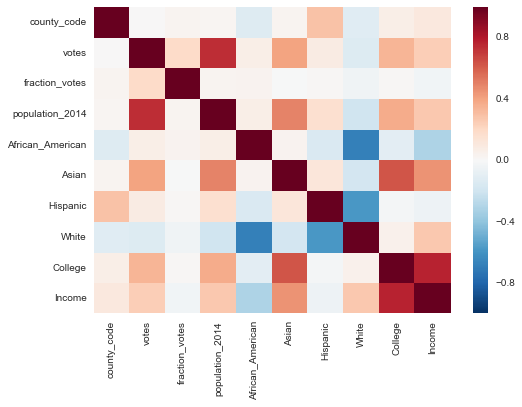

In [100]:
sns.heatmap(vote_and_county_data.corr()) #-- correlation matrix

In [101]:
vote_and_county_data.head()

,state,state_abbreviation,county,county_code,party,candidate,votes,fraction_votes,population_2014,African_American,Asian,Hispanic,White,College,Income
0,Alabama,AL,Autauga,1001,Republican,Donald Trump,5387,0.445,55395,18.7,1.1,2.7,75.6,20.9,24571
1,Alabama,AL,Autauga,1001,Republican,Ted Cruz,2482,0.205,55395,18.7,1.1,2.7,75.6,20.9,24571
2,Alabama,AL,Autauga,1001,Republican,Marco Rubio,1785,0.148,55395,18.7,1.1,2.7,75.6,20.9,24571
3,Alabama,AL,Autauga,1001,Republican,Ben Carson,1764,0.146,55395,18.7,1.1,2.7,75.6,20.9,24571
4,Alabama,AL,Autauga,1001,Republican,John Kasich,421,0.035,55395,18.7,1.1,2.7,75.6,20.9,24571


In [102]:
#-- FYI - ??? strange data, Republican party has more voters than Democratic party?  To check later.
vote_data.groupby("party").sum().sort_values("votes")

,county_code,votes,fraction_votes
party,,,
Democrat,117435772,11919638,1859.846
Republican,268169630,18324120,1831.451


In [103]:
vote_and_county_data.groupby("party").sum().sort_values("votes")

,county_code,votes,fraction_votes,population_2014,African_American,Asian,Hispanic,White,College,Income
party,,,,,,,,,,
Democrat,117435772,11919638,1859.846,337856175,47682.0,4364.7,38631.0,305898.4,76377.9,92569531
Republican,268169630,18324120,1831.451,735963078,112073.8,9778.3,83815.0,689030.3,166170.0,205651137


In [105]:
#-- filter by party 1 - use merged data set 1 and set 2
vote_data_democratic = vote_and_county_data[vote_and_county_data['party'] == 'Democrat']
vote_data_democratic.head()

,state,state_abbreviation,county,county_code,party,candidate,votes,fraction_votes,population_2014,African_American,Asian,Hispanic,White,College,Income
5,Alabama,AL,Autauga,1001,Democrat,Hillary Clinton,2387,0.800,55395,18.7,1.1,2.7,75.6,20.9,24571
6,Alabama,AL,Autauga,1001,Democrat,Bernie Sanders,544,0.182,55395,18.7,1.1,2.7,75.6,20.9,24571
12,Alabama,AL,Baldwin,1003,Democrat,Hillary Clinton,5290,0.647,200111,9.6,0.9,4.6,83.0,27.7,26766
13,Alabama,AL,Baldwin,1003,Democrat,Bernie Sanders,2694,0.329,200111,9.6,0.9,4.6,83.0,27.7,26766
19,Alabama,AL,Barbour,1005,Democrat,Hillary Clinton,2567,0.906,26887,47.6,0.5,4.5,46.6,13.4,16829


In [106]:
#-- ditto, filter by party 2 
#vote_data_republican = vote_data[vote_data['party'] == 'Republican']
vote_data_republican = vote_and_county_data[vote_data['party'] == 'Republican']
vote_data_republican.head()

,state,state_abbreviation,county,county_code,party,candidate,votes,fraction_votes,population_2014,African_American,Asian,Hispanic,White,College,Income
0,Alabama,AL,Autauga,1001,Republican,Donald Trump,5387,0.445,55395,18.7,1.1,2.7,75.6,20.9,24571
1,Alabama,AL,Autauga,1001,Republican,Ted Cruz,2482,0.205,55395,18.7,1.1,2.7,75.6,20.9,24571
2,Alabama,AL,Autauga,1001,Republican,Marco Rubio,1785,0.148,55395,18.7,1.1,2.7,75.6,20.9,24571
3,Alabama,AL,Autauga,1001,Republican,Ben Carson,1764,0.146,55395,18.7,1.1,2.7,75.6,20.9,24571
4,Alabama,AL,Autauga,1001,Republican,John Kasich,421,0.035,55395,18.7,1.1,2.7,75.6,20.9,24571


See who is the top candidate in each party

In [107]:
#-- get sum of votes by party and candidate - party 1
votes_candidate_democratic_group = vote_data_democratic.groupby(
                    ["party", "candidate"]).sum().sort_values("votes" )
votes_candidate_democratic_group

county_code    votes  fraction_votes  \
party    candidate                                               
Democrat  Uncommitted         1871660       43        0.045000   
          No Preference        200124      313        0.055000   
         Martin O'Malley      1871660      747        0.805000   
         Bernie Sanders      56746164  4740278      767.132879   
         Hillary Clinton     56746164  7178257     1091.808121   

                          population_2014  African_American   Asian  Hispanic  \
party    candidate                                                              
Democrat  Uncommitted             3093070             140.3   111.1     435.5   
          No Preference           3546635              51.2    26.9      79.2   
         Martin O'Malley          3093070             140.3   111.1     435.5   
         Bernie Sanders         164061700           23675.1  2057.8   18840.4   
         Hillary Clinton        164061700           23675.1  2057.8   18840.4   

                             White  College    Income  
party    candidate                                     
Democrat  Uncommitted       8987.7   1928.3   2507854  
          No Preference      638.2    294.7    285165  
         Martin O'Malley    8987.7   1928.3   2507854  
         Bernie Sanders   143642.4  36113.3  43634329  
         Hillary Clinton  143642.4  36113.3  43634329

In [108]:
#-- get sum of votes by party and candidate - party 2
votes_candidate_republican_group = vote_data_republican.groupby(
                    ["party", "candidate"]).sum().sort_values("votes" )
votes_candidate_republican_group

county_code    votes  fraction_votes  \
party      candidate                                              
Republican Rick Santorum       1871660     1773        0.979000   
           Mike Huckabee       1871660     3300        2.358000   
           Rand Paul           1871660     8460        3.356000   
           Carly Fiorina       2201760    15181        2.400571   
           Chris Christie      2201760    24347        1.932211   
           Jeb Bush            4273876    94394        6.887265   
           Ben Carson         32788263   528463       70.031066   
           John Kasich        55642760  2456406      155.088220   
           Marco Rubio        54160711  2998335      246.885603   
           Ted Cruz           55642760  5248807      595.865095   
           Donald Trump       55642760  6944654      745.667969   

                           population_2014  African_American   Asian  \
party      candidate                                                   
Republican Rick Santorum           3093070             140.3   111.1   
           Mike Huckabee           3093070             140.3   111.1   
           Rand Paul               3093070             140.3   111.1   
           Carly Fiorina           4419883             151.0   130.0   
           Chris Christie          4419883             151.0   130.0   
           Jeb Bush                9252365            1811.8   172.9   
           Ben Carson             77030395           13883.9  1151.4   
           John Kasich           160308932           23927.3  1978.2   
           Marco Rubio           150634546           23873.3  1926.1   
           Ted Cruz              160308932           23927.3  1978.2   
           Donald Trump          160308932           23927.3  1978.2   

                           Hispanic     White  College    Income  
party      candidate                                              
Republican Rick Santorum      435.5    8987.7   1928.3   2507854  
           Mike Huckabee      435.5    8987.7   1928.3   2507854  
           Rand Paul          435.5    8987.7   1928.3   2507854  
           Carly Fiorina      458.3    9920.2   2235.8   2814959  
           Chris Christie     458.3    9920.2   2235.8   2814959  
           Jeb Bush           663.6   12550.4   3099.1   3776843  
           Ben Carson       12596.5   70696.1  18265.9  22764169  
           John Kasich      17262.2  140555.1  33876.8  41728621  
           Marco Rubio      16545.2  137315.0  32918.1  40770782  
           Ted Cruz         17262.2  140555.1  33876.8  41728621  
           Donald Trump     17262.2  140555.1  33876.8  41728621

Chart it :

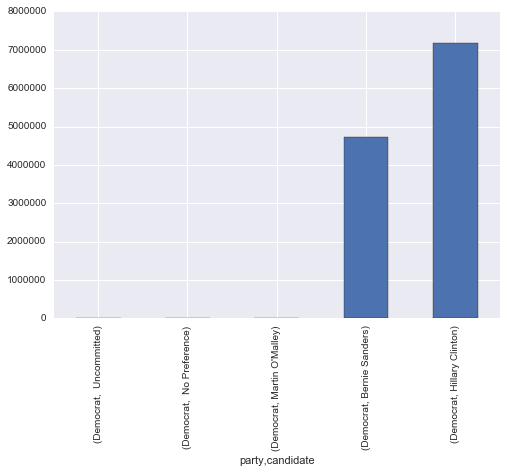

In [109]:
votes_candidate_democratic_group["votes"].plot(kind="bar")

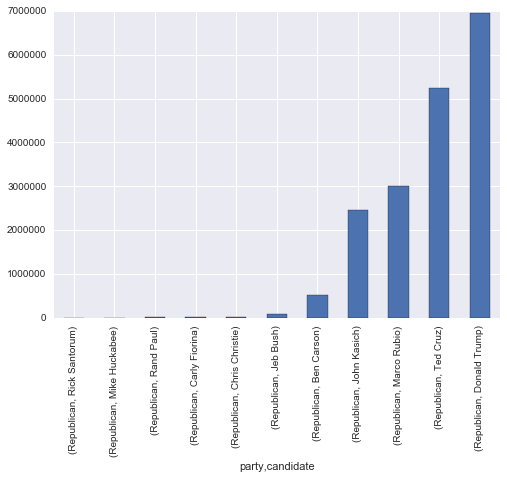

In [110]:
votes_candidate_republican_group["votes"].plot(kind="bar")

** Results: the top candidate for each party from above charts**
* Democratic - Clinton
* Republican   - Trump

In [111]:
print vote_data_democratic.shape
print vote_data_republican.shape

(4060, 15)
(9152, 15)


In [113]:
#vote_data_republican = vote_and_county_data[vote_data['party'] == 'Republican']
vote_data_republican.head()  #-- FYI - show the data
#-- stuck here #1

,state,state_abbreviation,county,county_code,party,candidate,votes,fraction_votes,population_2014,African_American,Asian,Hispanic,White,College,Income
0,Alabama,AL,Autauga,1001,Republican,Donald Trump,5387,0.445,55395,18.7,1.1,2.7,75.6,20.9,24571
1,Alabama,AL,Autauga,1001,Republican,Ted Cruz,2482,0.205,55395,18.7,1.1,2.7,75.6,20.9,24571
2,Alabama,AL,Autauga,1001,Republican,Marco Rubio,1785,0.148,55395,18.7,1.1,2.7,75.6,20.9,24571
3,Alabama,AL,Autauga,1001,Republican,Ben Carson,1764,0.146,55395,18.7,1.1,2.7,75.6,20.9,24571
4,Alabama,AL,Autauga,1001,Republican,John Kasich,421,0.035,55395,18.7,1.1,2.7,75.6,20.9,24571


**Was stuck here! ** Because cannot use the above data to predict y values i.e. **X looks the same for each county, so something odd about the above data!!!**.

In [37]:
#-- so need to find winnder by each county
#-- Average County Demographics by Winner
#vote_data_republican_group=vote_data_republican.groupby(['state', 'county_code', 'candidate']).sum().sort_values(['votes'], ascending=False)
vote_data_republican_group=vote_data_republican.groupby(['county_code', 'candidate']).sum()  #--??? not sure why, somehow this one looks like useable

print type(vote_data_republican.groupby(['county_code', 'candidate']).sum())  #-- FYI : 'pandas.core.frame.DataFrame'>
print type(vote_data_republican.groupby(['county_code', 'candidate'])) #-- FYI :'pandas.core.groupby.DataFrameGroupBy
vote_data_republican_group.head(10)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.groupby.DataFrameGroupBy'>


votes  fraction_votes  population_2014  \
county_code candidate                                              
1001        Ben Carson     1764           0.146            55395   
            Donald Trump   5387           0.445            55395   
            John Kasich     421           0.035            55395   
            Marco Rubio    1785           0.148            55395   
            Ted Cruz       2482           0.205            55395   
1003        Ben Carson     4221           0.084           200111   
            Donald Trump  23618           0.469           200111   
            John Kasich    2987           0.059           200111   
            Marco Rubio    9703           0.193           200111   
            Ted Cruz       8571           0.170           200111   

                          African_American  Asian  Hispanic  White  College  \
county_code candidate                                                         
1001        Ben Carson                18.7    1.1       2.7   75.6     20.9   
            Donald Trump              18.7    1.1       2.7   75.6     20.9   
            John Kasich               18.7    1.1       2.7   75.6     20.9   
            Marco Rubio               18.7    1.1       2.7   75.6     20.9   
            Ted Cruz                  18.7    1.1       2.7   75.6     20.9   
1003        Ben Carson                 9.6    0.9       4.6   83.0     27.7   
            Donald Trump               9.6    0.9       4.6   83.0     27.7   
            John Kasich                9.6    0.9       4.6   83.0     27.7   
            Marco Rubio                9.6    0.9       4.6   83.0     27.7   
            Ted Cruz                   9.6    0.9       4.6   83.0     27.7   

                          Income  
county_code candidate             
1001        Ben Carson     24571  
            Donald Trump   24571  
            John Kasich    24571  
            Marco Rubio    24571  
            Ted Cruz       24571  
1003        Ben Carson     26766  
            Donald Trump   26766  
            John Kasich    26766  
            Marco Rubio    26766  
            Ted Cruz       26766

In [38]:
#-- so start from the vote_data again (i.e. before any merge)
#vote_data.head()

In [39]:
vote_data_republican = vote_data[vote_data['party'] == 'Republican']
vote_data_republican.head()

,state,state_abbreviation,county,county_code,party,candidate,votes,fraction_votes
0,Alabama,AL,Autauga,1001,Republican,Donald Trump,5387,0.445
1,Alabama,AL,Autauga,1001,Republican,Ted Cruz,2482,0.205
2,Alabama,AL,Autauga,1001,Republican,Marco Rubio,1785,0.148
3,Alabama,AL,Autauga,1001,Republican,Ben Carson,1764,0.146
4,Alabama,AL,Autauga,1001,Republican,John Kasich,421,0.035


In [40]:
#-- get the Republican breakdown 

vote_data_republican_group=vote_data_republican.groupby(['county_code', 'candidate']).sum()  
#-- make it simple, so don't bother with state for now

print type(vote_data_republican.groupby(['county_code', 'candidate']).sum())  #-- FYI : 'pandas.core.frame.DataFrame'>
print type(vote_data_republican.groupby(['county_code', 'candidate'])) #-- FYI :'pandas.core.groupby.DataFrameGroupBy
vote_data_republican_group.head(15)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.groupby.DataFrameGroupBy'>


votes  fraction_votes
county_code candidate                          
1001        Ben Carson     1764           0.146
            Donald Trump   5387           0.445
            John Kasich     421           0.035
            Marco Rubio    1785           0.148
            Ted Cruz       2482           0.205
1003        Ben Carson     4221           0.084
            Donald Trump  23618           0.469
            John Kasich    2987           0.059
            Marco Rubio    9703           0.193
            Ted Cruz       8571           0.170
1005        Ben Carson      417           0.122
            Donald Trump   1710           0.501
            John Kasich     123           0.036
            Marco Rubio     498           0.146
            Ted Cruz        609           0.179

In [41]:
#-- this is complicated - next 
#-- step 1
vote_data_republican = vote_data[vote_data.party == "Republican"].reset_index()  #-- mask, filter
vote_data_republican.head(3)
print 
#-- step 2
vote_data_republican_group = vote_data_republican.groupby(["state_abbreviation", "county", 'county_code'])
print type(votes_candidate_republican_group)
vote_data_republican_group.head(3)


<class 'pandas.core.frame.DataFrame'>


,index,state,state_abbreviation,county,county_code,party,candidate,votes,fraction_votes
0,0,Alabama,AL,Autauga,1001,Republican,Donald Trump,5387,0.445000
1,1,Alabama,AL,Autauga,1001,Republican,Ted Cruz,2482,0.205000
2,2,Alabama,AL,Autauga,1001,Republican,Marco Rubio,1785,0.148000
5,7,Alabama,AL,Baldwin,1003,Republican,Donald Trump,23618,0.469000
6,8,Alabama,AL,Baldwin,1003,Republican,Marco Rubio,9703,0.193000
7,9,Alabama,AL,Baldwin,1003,Republican,Ted Cruz,8571,0.170000
10,14,Alabama,AL,Barbour,1005,Republican,Donald Trump,1710,0.501000
11,15,Alabama,AL,Barbour,1005,Republican,Ted Cruz,609,0.179000
12,16,Alabama,AL,Barbour,1005,Republican,Marco Rubio,498,0.146000
15,21,Alabama,AL,Bibb,1007,Republican,Donald Trump,1959,0.494000


In [42]:
#-- step 3 - TBA - to check syntax 
winner = vote_data_republican.loc[vote_data_republican_group['fraction_votes']\
        .transform('idxmax'),'candidate'].reset_index()    #-- to check syntax later
winner.head(10)

,index,candidate
0,0,Donald Trump
1,0,Donald Trump
2,0,Donald Trump
3,0,Donald Trump
4,0,Donald Trump
5,5,Donald Trump
6,5,Donald Trump
7,5,Donald Trump
8,5,Donald Trump
9,5,Donald Trump


In [46]:
#-- this data is not much usable yet
vote_data_republican["winner"] = winner['candidate']
vote_data_republican.head()

,index,state,state_abbreviation,county,county_code,party,candidate,votes,fraction_votes,winner,totalVotes
0,0,Alabama,AL,Autauga,1001,Republican,Donald Trump,5387,0.445,Donald Trump,5387
1,1,Alabama,AL,Autauga,1001,Republican,Ted Cruz,2482,0.205,Donald Trump,2482
2,2,Alabama,AL,Autauga,1001,Republican,Marco Rubio,1785,0.148,Donald Trump,1785
3,3,Alabama,AL,Autauga,1001,Republican,Ben Carson,1764,0.146,Donald Trump,1764
4,4,Alabama,AL,Autauga,1001,Republican,John Kasich,421,0.035,Donald Trump,421


In [48]:
#-- Find maximum value of a column and return the corresponding row values using Pandas
#-- ste4 
#vote_data_republican["winner"] = winner['candidate']
#vote_data_republican.head()
vote_data_republican["totalVotes"] = vote_data_republican["votes"]
vote_data_republican_winner_by_county = vote_data_republican_group.agg( \
            {"votes": max, "fraction_votes": max, "winner": "first", "votes": sum}) 
print type(vote_data_republican_winner_by_county)
#-- FYI - show sample results - for the county winnder is not Trump
vote_data_republican_winner_by_county[vote_data_republican_winner_by_county.winner!='Donald Trump'].head()

<class 'pandas.core.frame.DataFrame'>


votes       winner  fraction_votes
state_abbreviation county    county_code                                    
AR                 Benton    5007         41397  Marco Rubio           0.303
                   Carroll   5015             0   Ben Carson           0.000
                   Clark     5019          2597     Ted Cruz           0.345
                   Cleveland 5025          1460     Ted Cruz           0.368
                   Craighead 5031         12007     Ted Cruz           0.334

In [49]:
county_facts_data.head()
county_facts_data[county_facts_data.county_code == 5007].head()

,county_code,state_abbreviation,population_2014,African_American,Asian,Hispanic,White,College,Income
119,5007,AR,242321,1.9,3.4,16.2,74.9,28.7,26715


In [60]:
#-- to combine the 2 sets of data we are interested - vote_data and county_facts_data
#-- TBA - syntax error???
vote_data_republican_winner_by_county = vote_data_republican_winner_by_county.reset_index()#vote_data_republican_winner_by_county.columns

vote_and_county_data = vote_data_republican_winner_by_county.merge(county_facts_data\
         , on=['county_code'] \
        , left_index=True, right_index=True )
                                                    
vote_and_county_data.head(
#--ans: trick, use reset_index to flatten the groups into flat dataframes

,level_0,index,state_abbreviation_x,county,county_code,votes,winner,fraction_votes,state_abbreviation_y,population_2014,African_American,Asian,Hispanic,White,College,Income
2,2,2,AL,Barbour,1005,3357,Donald Trump,0.501,AL,55395,18.7,1.1,2.7,75.6,20.9,24571
3,3,3,AL,Bibb,1007,3891,Donald Trump,0.494,AL,200111,9.6,0.9,4.6,83.0,27.7,26766
4,4,4,AL,Blount,1009,14791,Donald Trump,0.487,AL,26887,47.6,0.5,4.5,46.6,13.4,16829
5,5,5,AL,Bullock,1011,541,Donald Trump,0.565,AL,22506,22.1,0.2,2.1,74.5,12.1,17427
6,6,6,AL,Butler,1013,3144,Donald Trump,0.538,AL,57719,1.8,0.3,8.7,87.8,12.1,20730


In [57]:
vote_data_republican_winner_by_county

,state_abbreviation,county,county_code,votes,winner,fraction_votes
0,AL,Autauga,1001,11839,Donald Trump,0.445
1,AL,Baldwin,1003,49100,Donald Trump,0.469
2,AL,Barbour,1005,3357,Donald Trump,0.501
3,AL,Bibb,1007,3891,Donald Trump,0.494
4,AL,Blount,1009,14791,Donald Trump,0.487
5,AL,Bullock,1011,541,Donald Trump,0.565
6,AL,Butler,1013,3144,Donald Trump,0.538
7,AL,Calhoun,1015,19377,Donald Trump,0.451
8,AL,Chambers,1017,4441,Donald Trump,0.476
9,AL,Cherokee,1019,5193,Donald Trump,0.521


In [425]:
#vote_data_republican_winner_by_county[vote_data_republican_winner_by_county.winner!='Donald Trump'].head()
#vote_data_republican_winner_by_county.head()

In [429]:
#-- alternative way - TBA
#-- clone 1 - borrow it
#-- https://www.kaggle.com/amirfz/d/benhamner/2016-us-election/predicting-results-based-on-demographics

#-- read file 1 - primary results

resultData = pd.read_csv("../../data/2016_presidential_election/primary_results.csv") 
resultDataGrouped = resultDataParty.groupby(["state_abbreviation", "county"])
winner = resultDataParty.loc[resultDataGrouped['fraction_votes'].transform('idxmax'),'candidate'].reset_index()
resultDataParty["winner"] = winner['candidate']
resultDataParty["totalVotes"] = resultDataParty["votes"]
votes = resultDataGrouped.agg({"votes": max, "fraction_votes": max, "winner": "first", "totalVotes": sum})

print votes.winner.unique() #-- my note
votes.head()

['Donald Trump' 'Marco Rubio' 'Ben Carson' 'Ted Cruz' 'John Kasich']


votes        winner  fraction_votes  totalVotes
state_abbreviation county                                                  
AL                 Autauga   5387  Donald Trump           0.445       11839
                   Baldwin  23618  Donald Trump           0.469       49100
                   Barbour   1710  Donald Trump           0.501        3357
                   Bibb      1959  Donald Trump           0.494        3891
                   Blount    7390  Donald Trump           0.487       14791

In [430]:
#-- clone 2 
demographicData  = pd.read_csv("../../data/2016_presidential_election/county_facts.csv")
availableStates = resultData.state_abbreviation.unique()
#availableStates = ['IA', 'NV']
#availableStates = ['SC', 'NH']

availableStatesDemoData = demographicData[demographicData.state_abbreviation.isin(availableStates)]\
                                [['state_abbreviation', 'area_name', 'INC110213', 'RHI725214', 'RHI825214', 'EDU685213',\
                                  'SEX255214','SBO015207','PST045214','POP645213','POP815213']].reset_index()
availableStatesDemoData.rename(columns={'area_name':'county', 'INC110213':'income', 'RHI725214':'hispanic', 
                                'RHI825214':'white', 'EDU685213':'education', 'SEX255214':'females',\
                                'SBO015207':'femaleFirmOwner', 'PST045214':'population','POP815213':'nonEn_language',\
                                'POP645213':'notBornInUS'}, inplace=True)
availableStatesDemoData['county'] = availableStatesDemoData['county'].str.replace(' County', '')
del availableStatesDemoData['index']
availableStatesDemoData["income"] = availableStatesDemoData["income"]/1000
availableStatesDemoData = availableStatesDemoData.set_index(["state_abbreviation", "county"])

In [431]:
#-- clone 3 
allData = pd.merge(votes, availableStatesDemoData, how="inner", left_index=True, right_index=True)
allData["turnout"] = allData.totalVotes/allData.population

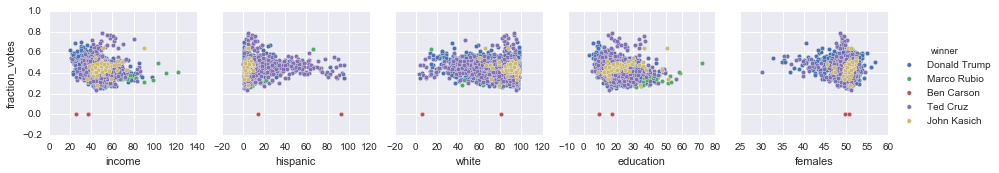

In [433]:
#-- clone 4 
sns.pairplot(allData, hue="winner", 
             x_vars = ["income", "hispanic", "white", "education", 'females'], 
             y_vars = ["fraction_votes"])

In [434]:
allData.head()
allData[allData.winner !='Donald Trump'].head()

votes       winner  fraction_votes  totalVotes  \
state_abbreviation county                                                      
AR                 Benton     12863  Marco Rubio           0.303       41397   
                   Carroll        0   Ben Carson           0.000           0   
                   Clark        907     Ted Cruz           0.345        2597   
                   Cleveland    550     Ted Cruz           0.368        1460   
                   Craighead   4108     Ted Cruz           0.334       12007   

                              income  hispanic  white  education  females  \
state_abbreviation county                                                   
AR                 Benton     54.515      16.2   74.9       28.7     50.5   
                   Carroll    36.584      14.6   81.1       17.3     50.7   
                   Clark      32.721       4.4   69.6       21.4     52.1   
                   Cleveland  39.420       2.2   84.7       13.8     51.1   
                   Craighead  41.393       4.7   78.0       24.4     51.3   

                              femaleFirmOwner  population  notBornInUS  \
state_abbreviation county                                                
AR                 Benton                23.7      242321         10.9   
                   Carroll               19.1       27744          6.8   
                   Clark                 26.8       22576          2.6   
                   Cleveland              0.0        8449          0.4   
                   Craighead              0.0      102518          3.7   

                              nonEn_language   turnout  
state_abbreviation county                               
AR                 Benton               15.5  0.170835  
                   Carroll              13.6  0.000000  
                   Clark                 5.2  0.115034  
                   Cleveland             0.9  0.172802  
                   Craighead             5.2  0.117121

In [435]:
#sns.heatmap(allData.corr())

In [437]:
#-- supervized learning - logistic regression
print votes.winner.unique()

['Donald Trump' 'Marco Rubio' 'Ben Carson' 'Ted Cruz' 'John Kasich']


In [438]:
#-- set from winner's name to some numeric value.  ??? there is room to improve by update all 5 names
#-- to keep it simple, just set 1 candidate, and the others 'non Trump' to be 0.  i.e. just 2 categories
allData["winner_number"] = (allData.winner=='Donald Trump').astype(int)  #-- main, make it numeric
#allData["winner_number"] = (allData.winner=='Marco Rubio').astype(int)


print allData[allData.winner=='Donald Trump'].winner_number.unique()  #-- expect to see 1
print allData[allData.winner!='Donald Trump'].winner_number.unique()  #-- expect to see 0
allData[allData.winner!='Donald Trump'].head() #-- check results, should see winner_number 1
#allData[allData.winner=='Donald Trump'].head() #-- check results, should see winner_number 0

[1]
[0]


votes       winner  fraction_votes  totalVotes  \
state_abbreviation county                                                      
AR                 Benton     12863  Marco Rubio           0.303       41397   
                   Carroll        0   Ben Carson           0.000           0   
                   Clark        907     Ted Cruz           0.345        2597   
                   Cleveland    550     Ted Cruz           0.368        1460   
                   Craighead   4108     Ted Cruz           0.334       12007   

                              income  hispanic  white  education  females  \
state_abbreviation county                                                   
AR                 Benton     54.515      16.2   74.9       28.7     50.5   
                   Carroll    36.584      14.6   81.1       17.3     50.7   
                   Clark      32.721       4.4   69.6       21.4     52.1   
                   Cleveland  39.420       2.2   84.7       13.8     51.1   
                   Craighead  41.393       4.7   78.0       24.4     51.3   

                              femaleFirmOwner  population  notBornInUS  \
state_abbreviation county                                                
AR                 Benton                23.7      242321         10.9   
                   Carroll               19.1       27744          6.8   
                   Clark                 26.8       22576          2.6   
                   Cleveland              0.0        8449          0.4   
                   Craighead              0.0      102518          3.7   

                              nonEn_language   turnout  winner_number  
state_abbreviation county                                              
AR                 Benton               15.5  0.170835              0  
                   Carroll              13.6  0.000000              0  
                   Clark                 5.2  0.115034              0  
                   Cleveland             0.9  0.172802              0  
                   Craighead             5.2  0.117121              0

In [440]:
#-- Supervized learning - logistic regression
#-- predict vote_data_republican  (ditto could be done for vote_data_democratic but the answer is known already per news)
# define X and y

logreg = LogisticRegression(C=1e9)

feature_cols = ['income', 'hispanic', 'white', 'education']
X = allData[feature_cols]
y = allData.winner_number

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)

logreg.fit(X_train, y_train)
y_test_pred = logreg.predict(X_test)
print y_test_pred
print 
print "Test set accuracy of LR model: ", metrics.accuracy_score(y_test, y_test_pred)

[1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1
 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0
 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1
 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1
 0 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1
 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1
 0 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1
 1 0 0 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 0 1 0 0 1 1 1 1 1 0 1 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 1 0 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 1 0
 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 0 0 1 0 0 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 0 1 1 

C:\Program Files (x86)\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


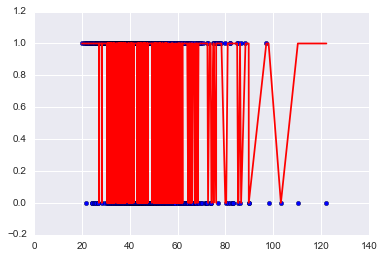

In [441]:
#-- TBA - this is not what I want.  I want to plot multiple features on X (income, education,etc) vs y (winner)
import matplotlib.pyplot as plt
allData['winner_number_predict'] = winner_number_predict
# sort DataFrame by pelvic_incidence so that the line plot makes sense
allData.sort('income', inplace=True)
#allData.sort('county', inplace=True)

plt.scatter(allData.income, allData.winner_number)
plt.plot(allData.income, winner_number_predict, color='red')


#-- TBA - try to predict who will win a county based on demographics.
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, min_samples_leaf=10)

model.fit(train, y_train)

### What learned from this exercise :
* Data exploration - even the initial data sets seem clean - actually still need data exploration to make it useful. For example, NaN in this data set is 'State Level' info. And also need to aggregrate data by county so as to have some meaningful info.
* Merge data sets - merge normalized data sets as needed. e.g. primary voting results and county demographics data
* Visualization - heatmap, bar chart, etc
* Prediction - turned out data munging more complicated that originally expected.
* Q: Why not predict who will win 'Clinton' vs 'Trump' ? A: coz this data set is about primary result, need more info if want to prefict general election
* **Through this couse - look at the data at different level from before**

